####  Notebook for data cleaning and merging
This note book generate the uscountypciome.pgkg file which is used in the main notebook for analysis. The county income data is from the [US census bureau](https://www2.census.gov/geo/tiger/) The data is cleaned and merged with the county shape file. The data is then saved as a pickle file for further analysis.

In [1]:
import pandas as pd
from zipfile import ZipFile
import glob
from urllib.request import urlopen
from io import BytesIO
import fiona.io
import geopandas as gpd
import pandas
import requests
import topojson as tp

In [2]:
# read and conver to shp
gdf = gpd.read_file('tl_2021_us_county.zip')
topo = tp.Topology(gdf, prequantize=False)
gdf_simplified = topo.toposimplify(5).to_gdf()
gdf_simplified.to_file('tl_2021_us_county.shp')

#### Read the cianc4 file with county income data

In [3]:
csv_files = glob.glob("*.csv")

In [4]:
# get cianc4 csv which has all the county income data
data = pandas.read_csv('CAINC4__ALL_AREAS_1969_2021.csv', encoding='latin-1', 
                      skipfooter=3, engine='python')

In [5]:
data.head()

,GeoFIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,1969,1970,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,"""00000""",United States,,CAINC4,10.0,...,Personal income (thousands of dollars),Thousands of dollars,791229000,855525000,...,14003346000,14189228000,14969527000,15681233000,16092713000,16837337000,17671054000,18575467000,19812171000,21288709000
1,"""00000""",United States,,CAINC4,11.0,...,Nonfarm personal income 1/,Thousands of dollars,773954000,838026000,...,13912005000,14065574000,14867407000,15592764000,16023802000,16763400000,17609130000,18511204000,19734012000,21194412000
2,"""00000""",United States,,CAINC4,12.0,...,Farm income 2/,Thousands of dollars,17275000,17499000,...,91341000,123654000,102120000,88469000,68911000,73937000,61924000,64263000,78159000,94297000
3,"""00000""",United States,,CAINC4,20.0,...,Population (persons) 3/,Number of persons,201298000,203798722,...,314344331,316735375,319270047,321829327,324367742,326623063,328542157,330233102,331501080,331893745
4,"""00000""",United States,,CAINC4,30.0,...,Per capita personal income (dollars) 4/,Dollars,3931,4198,...,44548,44798,46887,48725,49613,51550,53786,56250,59765,64143


In [6]:
tennessee = data[data.GeoFIPS.str.contains('\"47')] # select tennessee
tennessee.head()


,GeoFIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,1969,1970,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
57408,"""47000""",Tennessee,5,CAINC4,10.0,...,Personal income (thousands of dollars),Thousands of dollars,11815600,12849372,...,254470632,256753847,267288734,281281093,290239862,302461645,319022245,338609203,362278148,394520369
57409,"""47000""",Tennessee,5,CAINC4,11.0,...,Nonfarm personal income 1/,Thousands of dollars,11561536,12581636,...,254144228,255744345,266905074,280940270,290271722,302440222,319346439,338588629,362340628,393940415
57410,"""47000""",Tennessee,5,CAINC4,12.0,...,Farm income 2/,Thousands of dollars,254064,267736,...,326404,1009502,383660,340823,-31860,21423,-324194,20574,-62480,579954
57411,"""47000""",Tennessee,5,CAINC4,20.0,...,Population (persons) 3/,Number of persons,3897000,3936975,...,6463111,6507640,6558710,6612901,6672356,6739437,6806545,6862378,6920119,6975218
57412,"""47000""",Tennessee,5,CAINC4,30.0,...,Per capita personal income (dollars) 4/,Dollars,3032,3264,...,39373,39454,40753,42535,43499,44879,46870,49343,52351,56560


In [7]:
tennessee.shape

(2208, 61)

In [8]:
tennessee.to_csv('tennessee.csv')

In [9]:
# get the fips codes for each state
states = [
    "Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", 
    "Connecticut", "Delaware", "Florida", "Georgia", "Hawaii", "Idaho", 
    "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", "Maine", 
    "Maryland", "Massachusetts", "Michigan", "Minnesota", "Mississippi", 
    "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey", 
    "New Mexico", "New York", "North Carolina", "North Dakota", "Ohio", 
    "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", 
    "South Dakota", "Tennessee", "Texas", "Utah", "Vermont", "Virginia", 
    "Washington", "West Virginia", "Wisconsin", "Wyoming"
]

abbreviations = [
    "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", "HI", "ID", 
    "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS", 
    "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY", "NC", "ND", "OH", "OK", 
    "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", 
    "WI", "WY"
]

fips_codes = [
    "01", "02", "04", "05", "06", "08", "09", "10", "12", "13", "15", "16", 
    "17", "18", "19", "20", "21", "22", "23", "24", "25", "26", "27", "28", 
    "29", "30", "31", "32", "33", "34", "35", "36", "37", "38", "39", "40", 
    "41", "42", "44", "45", "46", "47", "48", "49", "50", "51", "53", "54", 
    "55", "56"
]

fips_df = pd.DataFrame({'State': states, 'Abbreviation': abbreviations, 'FIPS': fips_codes})


In [10]:
geofips = set(code[:4] for code in data.GeoFIPS.values)

In [11]:
for fip in geofips:
    sdf = data[data.GeoFIPS.str.contains(fip)]
    sdf.to_csv(fip[2:]+".csv")

## Read county geometries

In [12]:
gdf = gpd.read_file("tl_2021_us_county.shp")

## State Specific Data Frames

In [13]:
csv_files = glob.glob("??.csv")
csv_files.sort()

In [14]:
# check if missmatch
mismatch = []
gdfs = []
#for csv_file in csv_files[:1]:
for csv_file in csv_files:

    #print(csv_file)
    csv = pandas.read_csv(csv_file)
    st = csv_file[:2]
    st_gdf = gdf[gdf.STATEFP==st]

    csv['GeoFIPS'] = [fip.strip().replace("\"", "") for fip in csv.GeoFIPS]
    csv['GEOID'] = csv.GeoFIPS.astype(str)
    merged_gdf = st_gdf.merge(csv, on='GEOID')
    gdfs.append(merged_gdf)

In [15]:
gdf = pandas.concat(gdfs)

<Axes: >

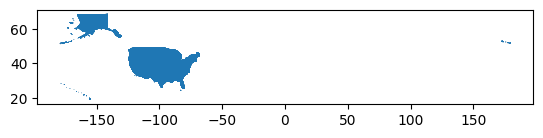

In [16]:
gdf.plot()

In [17]:
gdf.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry', 'Unnamed: 0', 'GeoFIPS',
       'GeoName', 'Region', 'TableName', 'LineCode', 'IndustryClassification',
       'Description', 'Unit', '1969', '1970', '1971', '1972', '1973', '1974',
       '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983',
       '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992',
       '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001',
       '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010',
       '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019',
       '2020', '2021', 'GEOID'],
      dtype='object')

In [18]:
# check line code, only keep linecode with 30
gdf.LineCode

0        10.0
1        11.0
2        12.0
3        20.0
4        30.0
        ...  
524      71.0
525      72.0
526    7010.0
527    7020.0
528    7040.0
Name: LineCode, Length: 71070, dtype: float64

In [19]:
gdf = gdf[gdf.LineCode==30]

In [20]:
gdf.shape

(3090, 80)

In [21]:
gdf

,STATEFP,COUNTYFP,COUNTYNS,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,GEOID
4,01,027,00161539,Clay,Clay County,06,H1,G4020,None,None,...,27443,28629,29998,29778,30213,31060,32059,34660,38705,01027
27,01,091,00161572,Marengo,Marengo County,06,H1,G4020,None,None,...,33194,34269,35263,35706,36174,38278,39394,43596,47008,01091
50,01,049,00161550,DeKalb,DeKalb County,06,H1,G4020,497,22840,...,28126,28977,30675,29973,31098,32174,33015,34999,40026,01049
73,01,019,00161535,Cherokee,Cherokee County,06,H1,G4020,None,None,...,31534,32688,34898,34711,35613,37085,37751,39416,43719,01019
96,01,065,00161558,Hale,Hale County,06,H1,G4020,None,46220,...,31881,31778,33843,34491,34904,35303,37619,40633,44085,01065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,56,033,01605081,Sheridan,Sheridan County,06,H1,G4020,None,43260,...,49343,54434,52682,53086,55109,58364,59932,61749,64449,56033
441,56,027,01605078,Niobrara,Niobrara County,06,H1,G4020,None,None,...,40775,46452,44551,41590,45122,48334,45633,50469,53797,56027
464,56,039,01605083,Teton,Teton County,06,H1,G4020,None,27220,...,177810,201780,199786,207571,228049,221209,278682,290674,318297,56039
487,56,035,01605082,Sublette,Sublette County,06,H1,G4020,None,None,...,55720,57348,55877,51434,56145,60971,61618,62780,65620,56035


In [22]:
years = [str(year) for year in range(1969,2018)]
dtypes = list(zip(years,[gdf[year].dtype for year in years]))


<Axes: >

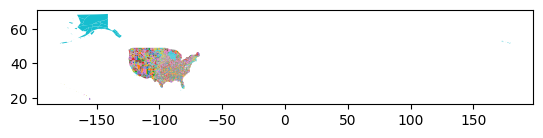

In [23]:
gdf.plot(column='2021')

In [24]:
gdf.to_file("uscountypcincome.gpkg", layer='pcincome', driver="GPKG")